In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.animation as animation
import healpy as hp

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import os
from collections import namedtuple
from celerite import GP
from celerite.terms import Matern32Term
import pymc3 as pm
from pymc3.smc import sample_smc
import theano
from corner import corner
from matplotlib.gridspec import GridSpec


from lightkurve import search_lightcurvefile

# lcf = search_lightcurvefile("Kepler-411", mission='Kepler').download_all()
# lc = lcf.PDCSAP_FLUX.stitch()

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pickle

def load_trace(name): 
    with open(name, 'rb') as buff: 
        trace = pickle.load(buff)
    return trace

In [215]:
!ls abdor_good_2

abdor_0.pkl abdor_1.pkl abdor_2.pkl abdor_3.pkl abdor_4.pkl


In [439]:
i = 0
n_spots = 4


In [456]:
ld.shape

(250, 250)

In [459]:
ld.shape, on_star.shape

((250, 250), (250, 250))

In [ ]:
star = 'AB Dor'

LightCurve = namedtuple("LightCurve", ['time', 'flux', 'flux_err'])

if os.path.exists('abdor_lc.npy'): 
    t, f, e = np.load('abdor_lc.npy')
    lc = LightCurve(time=t, flux=f, flux_err=e)
else: 
    lcf = search_lightcurvefile(star, mission='TESS').download_all()
    lc = lcf.PDCSAP_FLUX.stitch()
    
t, f, e = lc.time[~np.isnan(lc.flux)], lc.flux[~np.isnan(lc.flux)], lc.flux_err[~np.isnan(lc.flux)]

for i in range(1, 5):
    max_time = t.min() + 7 + 7 * i 
    min_time = t.min() + 7 * i 
    trace = load_trace(f"abdor_good_2/abdor_{i}.pkl")
    
    skip = 10

    t1, f1, e1 = t[(t < max_time) & (t > min_time)][::skip], f[(t < max_time) & (t > min_time)][::skip], e[(t < max_time) & (t > min_time)][::skip]


    # plt.ion()
    ln_shear = np.median(trace[f'{n_spots}_ln_shear'])
    complement_to_inclination = np.median(trace[f'{n_spots}_inc'])
    eq_period = np.median(trace[f'{n_spots}_P_eq'])
    fluxoffset = np.median(trace[f'{n_spots}_f0'])
    print(f"complement_to_inclination {np.degrees(complement_to_inclination)}")

    samples = pm.trace_to_dataframe(trace).values
    spot_props = np.median(samples[:, 4:], axis=0).reshape((n_spots, 3))
    spot_model = 1
    spot_lons = spot_props[:, 0]
    spot_lats = spot_props[:, 1]
    spot_rads = spot_props[:, 2]
    print(spot_rads)
    xsize = 250
    xgrid = np.linspace(-1, 1, xsize)
    xx, yy = np.meshgrid(xgrid, xgrid)
    m = np.zeros((xsize, xsize, len(t1)))

    r = np.hypot(xx, yy)
    ld = (1 - 0.4 * r**2 - 0.2 * r) / (1 - 0.4/3 - 0.2/6)
    
    on_star = np.hypot(xx, yy) <= 1
    m[..., :] = (ld * on_star.astype(int))[..., None]
    
        
    for spot_ind in range(n_spots):
        period_i = eq_period / (1 - np.exp(ln_shear) * np.sin(spot_lats[spot_ind] - np.pi/2)**2)
        phi = 2 * np.pi / period_i * (t1 - t1.mean()) - spot_lons[spot_ind] #+ np.pi

        spot_position_x = (np.cos(phi - np.pi/2) * np.sin(complement_to_inclination) * np.sin(spot_lats[spot_ind]) + 
                           np.cos(complement_to_inclination) * np.cos(spot_lats[spot_ind]))
        spot_position_y = -np.sin(phi - np.pi/2) * np.sin(spot_lats[spot_ind])
        spot_position_z = (np.cos(spot_lats[spot_ind]) * np.sin(complement_to_inclination) - np.sin(phi) * 
                           np.cos(complement_to_inclination) * np.sin(spot_lats[spot_ind]))

        rsq = spot_position_x**2 + spot_position_y**2
        contrast = 0.4
        spot_model -= spot_rads[spot_ind]**2 * (1 - contrast) * np.where(spot_position_z > 0, np.sqrt(1 - rsq), 0)

        foreshorten_semiminor_axis = np.sqrt(1 - rsq)

        a = spot_rads[spot_ind]
        b = spot_rads[spot_ind] * foreshorten_semiminor_axis  # Semi-minor axis
        A = np.pi/2 + np.arctan2(spot_position_y, spot_position_x)[None, None, :]  # Semi-major axis rotation
        on_spot = (((xx[:, :, None] - spot_position_x[None, None, :]) * np.cos(A) +
                    (yy[:, :, None] - spot_position_y[None, None, :]) * np.sin(A))**2 / a**2 +
                   ((xx[:, :, None] - spot_position_x[None, None, :]) * np.sin(A) -
                    (yy[:, :, None] - spot_position_y[None, None, :]) * np.cos(A))**2 / b**2 <= 1)
        on_spot *= spot_position_z[None, None, :] > 0
        m[on_spot] *= 1 - contrast

    plt.imshow(m.mean(axis=2))
    plt.show()
        
    with pm.Model(name=f'{n_spots}') as model1:

        f0 = pm.Uniform("f0", lower=0, upper=1)
        spot_model = 1 + f0
        eq_period = pm.Uniform("P_eq", lower=0.4, upper=0.6)
        ln_shear = pm.Uniform("ln_shear", lower=-100, upper=np.log(0.6))
        inclination = pm.Uniform("inc", lower=np.radians(0), upper=np.radians(90))
        lon_lims = 2 * np.pi * np.arange(n_spots + 1) / n_spots

        for spot_ind in range(n_spots):
            latitude_cutoff = 10
            lon = pm.Uniform(f"lon_{spot_ind}", lower=lon_lims[spot_ind], upper=lon_lims[spot_ind+1])
            lat = pm.Uniform(f"lat_{spot_ind}", lower=np.radians(latitude_cutoff), upper=np.radians(180-latitude_cutoff))
            rspot = pm.Uniform(f"R_spot_{spot_ind}", lower=0.001, upper=0.8)

            period_i = eq_period / (1 - pm.math.exp(ln_shear) * pm.math.sin(lat - np.pi/2)**2)
            phi = 2 * np.pi / period_i * (t1 - t1.mean()) - lon

            spot_position_x = (pm.math.cos(phi - np.pi/2) * pm.math.sin(inclination) * pm.math.sin(lat) + 
                               pm.math.cos(inclination) * pm.math.cos(lat))
            spot_position_y = -pm.math.sin(phi - np.pi/2) * pm.math.sin(lat)
            spot_position_z = (pm.math.cos(lat) * pm.math.sin(inclination) - pm.math.sin(phi) * 
                               pm.math.cos(inclination) * pm.math.sin(lat))

            rsq = spot_position_x**2 + spot_position_y**2
            contrast = 0.4
            spot_model -= rspot**2 * (1 - contrast) * pm.math.where(spot_position_z > 0, pm.math.sqrt(1 - rsq), 0)

        pm.Normal("obs", mu=spot_model, 
                  sigma=1 * e1,
                  observed=f1)
    with model1:
        ppc = pm.sample_posterior_predictive(trace, samples=10)

    %matplotlib notebook
    # Frames per second
    fps = 10
    gs = GridSpec(1, 5)
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( 
        figsize=(7, 2),
        dpi=250
    )
    gs = GridSpec(1, 5, figure=fig)

    ax_image = plt.subplot(gs[0:2])

    im = ax_image.imshow(m[..., 0], 
        aspect='equal', 
        cmap=plt.cm.copper,
        extent=[-1, 1, -1, 1], 
        vmin=0, 
        vmax=1, 
        origin='lower'
    )
    ax_image.axis('off')

    ax_lc = plt.subplot(gs[2:])
    ax_lc.plot(t1, ppc[f'{n_spots}_obs'].T, color='DodgerBlue', alpha=0.05)
    ax_lc.plot(t1, f1, '.', color='k')
    #     ax_lc.plot(t1, fakelc, color='r', alpha=0.1)
    ax_lc.set(xlabel='Time', ylabel='Flux')

    for sp in ['right', 'top']:
        ax_lc.spines[sp].set_visible(False)
    time_marker = ax_lc.axvline(t1[0], ls='--', color='gray')

    def animate_func(ii):
        if ii % fps == 0:
            print('.', end='')

        im.set_array(np.ma.masked_array(m[..., ii].T, m[..., ii].T == 0))

        time_marker.set_data([t1[ii], t1[ii]], [0, 1])

        return [im]
    fig.tight_layout()
    anim = animation.FuncAnimation(
       fig, 
       animate_func, 
       frames = m.shape[2], 
       interval = 1000 / fps, # in ms
    )

    anim.save(f'vis/abdor_{i}.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
    print('done.')



complement_to_inclination 37.87968213801726
[0.29514008 0.38036546 0.45206128 0.29485698]


<IPython.core.display.Javascript object>

/Users/bmmorris/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:1679: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


<IPython.core.display.Javascript object>

.............................................done.
complement_to_inclination 34.31600129413668
[0.5381777  0.3892634  0.28407742 0.40562495]


/Users/bmmorris/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:1679: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Traceback (most recent call last):
  File "/Users/bmmorris/.local/lib/python3.7/site-packages/matplotlib-3.1.1-py3.7-macosx-10.9-x86_64.egg/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/Users/bmmorris/.local/lib/python3.7/site-packages/matplotlib-3.1.1-py3.7-macosx-10.9-x86_64.egg/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>

.................................................done.


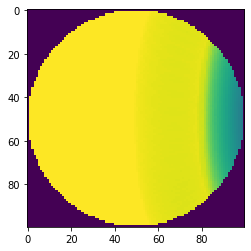

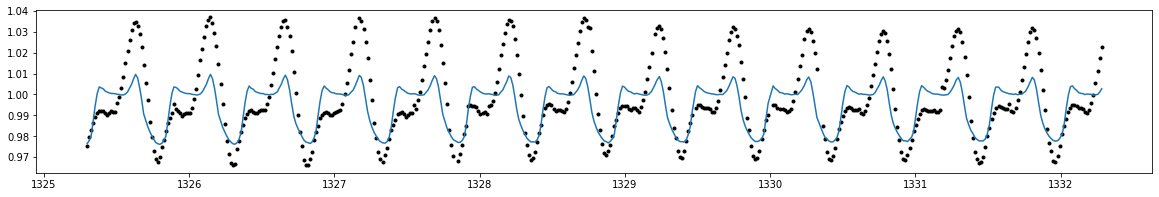

In [445]:
%matplotlib inline
plt.figure(figsize=(20, 3)) 
plt.plot(t1, f1, '.', color='k')
m_model = m.sum(axis=(0, 1))
fakelc = m_model / np.median(m_model)
plt.plot(t1, fakelc)

<IPython.core.display.Javascript object>

..........................done.


<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/Users/bmmorris/.local/lib/python3.7/site-packages/matplotlib-3.1.1-py3.7-macosx-10.9-x86_64.egg/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/Users/bmmorris/.local/lib/python3.7/site-packages/matplotlib-3.1.1-py3.7-macosx-10.9-x86_64.egg/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [132]:
on_spot.shape

(100, 100, 254)

In [65]:
A.shape

(1, 1, 269)

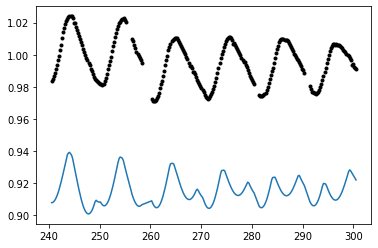

In [34]:
plt.plot(t1, spot_model)
plt.plot(t1, f1, '.', color='k')